In [1]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import subprocess
import pydotplus
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# 数据导入
xls_file = pd.ExcelFile('alliance.xls')
# print(xls_file.sheet_names)
df = xls_file.parse('sheet1')
df_target = df['result']

In [2]:
# # 对范畴类变量进行编码   # disabled due to suspect this is useless.
# for column in ['(L)HTTPstatus']:
#     dummies = pd.get_dummies(df[column])
#     df[dummies.columns]=dummies

print(df.shape)
    
# 去掉已编码的原属性
df.drop(['domain','(L)HTTPstatus'], axis=1, inplace=True)
#df.ix[:,df.columns!=999]

(1241, 19)


In [3]:
# 拆分数据集为训练集和测试集
train, test = train_test_split(df, test_size = 0.2)   # doing split of training and testing
train_data, train_target= train.ix[:, train.columns != 'result'], train['result']
test_data, test_target = test.ix[:, test.columns != 'result'], test['result']
# print(train_data.shape)
# print(train_target.shape)
# headers = train_data.dtypes.index
# print(headers)

In [4]:
# GradientBoost
# 可控制参数为 n_estimators, max_depth
# For datasets with a large number of classes we strongly recommend to use RandomForestClassifier as an alternative to GradientBoostingClassifier .
#clf = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=2, random_state=0)
#clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, subsample=0.8, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')

clf.fit(train_data,train_target)
score = clf.score(train_data, train_target)
clf_err = 1.0 - score
print(score)

0.989919354839


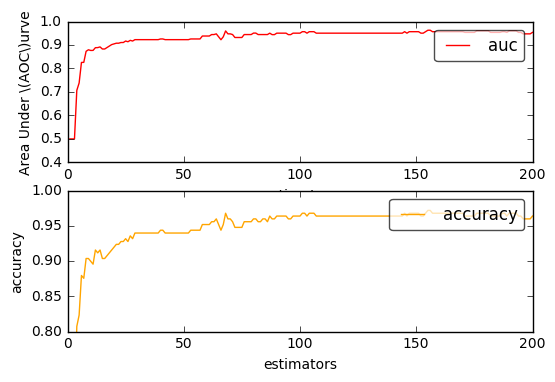

In [5]:
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

fig = plt.figure()

ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax2 = fig.add_subplot(111)

n_estimators=200

GB_zero_one_loss=np.zeros((n_estimators,))
GB_accuracy=np.zeros((n_estimators,))
GB_auc=np.zeros((n_estimators,))

for i, y_pred in enumerate(clf.staged_predict(test_data)):
    #GB_zero_one_loss[i] = zero_one_loss(test_target , y_pred)
    GB_accuracy[i]=accuracy_score(test_target , y_pred)
    GB_auc[i]= roc_auc_score(test_target , y_pred)
    #print(GB_auc[i])


ax.plot(np.arange(n_estimators) + 1, GB_auc,
        label='auc',
        color='red')
ax.set_ylim((0.8, 1.0))
ax.set_xlabel('estimators')
ax.set_ylabel('Area Under \(AOC\)urve')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

ax2.plot(np.arange(n_estimators) + 1, GB_accuracy,
        label='accuracy',
        color='orange')

ax2.set_xlabel('estimators')
ax2.set_ylabel('accuracy')
ax2.set_ylim((0.8, 1.0))

leg2 = ax2.legend(loc='upper right', fancybox=True)
leg2.get_frame().set_alpha(0.7)

plt.show()

In [6]:
print("↓↓↓↓ Test ↓↓↓↓")
test_accuracy = cross_val_score(clf, test_data, test_target, cv=30,scoring='accuracy')
test_recall = cross_val_score(clf, test_data, test_target, cv=30,scoring='recall')
test_precision = cross_val_score(clf, test_data, test_target, cv=30,scoring='precision')
test_f1 = cross_val_score(clf, test_data, test_target, cv=30,scoring='f1')

print("Test_Accuracy avg 30 >> \n",np.mean(test_accuracy))
print("Test_Recall avg 30 >> \n",np.mean(test_recall))
print("Test_Precision avg 30 >> \n",np.mean(test_precision))
print("Test_F1 avg 30 >> \n",np.mean(test_f1))

↓↓↓↓ Test ↓↓↓↓
Test_Accuracy avg 30 >> 
 0.909656084656
Test_Recall avg 30 >> 
 0.877777777778
Test_Precision avg 30 >> 
 0.882777777778
Test_F1 avg 30 >> 
 0.875396825397


In [7]:
# # 预测数据
# to_predict_file = pd.ExcelFile('predict.xls')
# #print(xls_file.sheet_names)  # check what Sheet name the file has.
# predict_set = to_predict_file.parse('Sheet1')
# predict_set.drop(['domain','(L)HTTPstatus','result'], axis=1, inplace=True)
# print(predict_set.shape)

# clf.predict(predict_set)
# clf.predict_log_proba(predict_set)